# Langevin dynamics on 4-well 1D landscape: slow modes from MSM and S(N)RV w/ and w/out path reweighting using overdamped EM integrator

## setup

In [1]:
import os
import sys
import math
import time
import pickle
import copy

import numpy as np
from scipy.linalg import eigh
from scipy.interpolate import interp1d
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm import tqdm

In [2]:
from snrv import Snrv, load_snrv

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# fix random seed for reproducibility
np.random.seed(200184)
torch.manual_seed(200184)

### defining potential energy landscape

#### 4-well landscape

In [6]:
def potential_4well(x):
    V = 2*x**8 + 1.6*np.exp(-80.0*x**2) + 0.4*np.exp(-80.0*(x-0.5)**2) + 1.0*np.exp(-40.0*(x+0.5)**2)
    return V

In [7]:
def force_4well(x):
    f = -16.0*x**7 + 256.0*x*np.exp(-80.0*x**2) + 64.0*(x-0.5)*np.exp(-80.0*(x-0.5)**2) + 80.0*(x+0.5)*np.exp(-40.0*(x+0.5)**2)
    return f

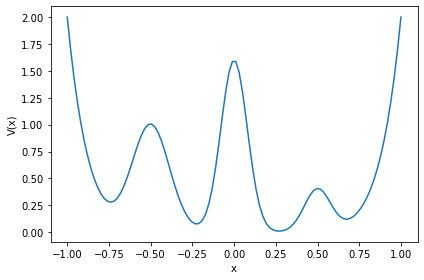

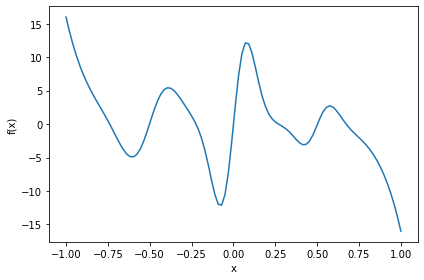

In [8]:
x_list = np.linspace(-1, 1, 100)
V_list = potential_4well(x_list)
f_list = force_4well(x_list)

fig, ax = plt.subplots()
ax.plot(x_list, V_list)
ax.set_xlabel('x')
ax.set_ylabel('V(x)')
fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(x_list, f_list)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
fig.tight_layout()

#### 2-well landscape

In [9]:
def potential_2well(x):
    V = 2*x**8 + 1.6*np.exp(-80.0*x**2)
    return V

In [10]:
def force_2well(x):
    f = -16.0*x**7 + 256.0*x*np.exp(-80.0*x**2)
    return f

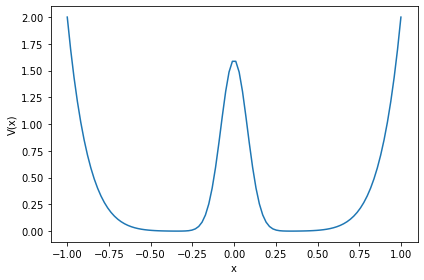

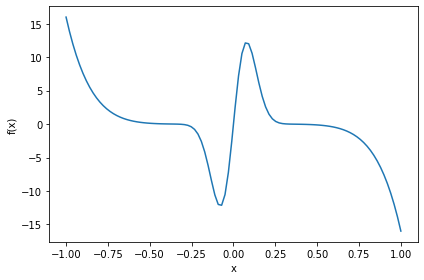

In [11]:
x_list = np.linspace(-1, 1, 100)
V_list = potential_2well(x_list)
f_list = force_2well(x_list)

fig, ax = plt.subplots()
ax.plot(x_list, V_list)
ax.set_xlabel('x')
ax.set_ylabel('V(x)')
fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(x_list, f_list)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
fig.tight_layout()

### defining integrator choices

#### overdamped Langevin - Euler-Maruyama
#### [Eqn. 12] Kieninger and Keller J. Chem. Phys. 154, 094102 (2021); doi: 10.1063/5.0038408

In [12]:
def integrator_EM(x,f,xi,m,kT,dt,eta):
    x_new = x + f/(xi*m)*dt + np.sqrt(2.0*kT*dt/(xi*m))*eta
    return x_new

#### Langevin - ISP
#### [Eqn. 20,21] Kieninger and Keller J. Chem. Phys. 154, 094102 (2021); doi: 10.1063/5.0038408

In [13]:
def integrator_ISP(x,v,f,xi,m,kT,dt,eta):
    gamma = np.exp(-xi*dt)
    x_new = x + gamma*v*dt + (1-gamma)*f/(xi*m)*dt + np.sqrt(kT/m*(1-gamma**2))*eta*dt
    v_new = (x_new - x)/dt
    return x_new, v_new

#### Langevin - BAOAB
#### [p. 54] B. Leimkuhler and C. Matthews (2013) “Stochastic Numerical Methods for Molecular Sampling,” Applied Mathematics Research eXpress, Vol. 2013, No. 1, pp. 34–56 https://dx.doi.org/10.1093/amrx/abs010
#### [Eqn. 4] JOSHUA FINKELSTEIN, GIACOMO FIORIN, AND BENJAMIN SEIBOLD "COMPARISON OF MODERN LANGEVIN INTEGRATORS FOR SIMULATIONS OF COARSE-GRAINED POLYMER MELTS" https://arxiv.org/pdf/1904.00532.pdf

In [14]:
def integrator_BAOAB(x,v,f,xi,m,kT,dt,eta,force_target,force_bias):
    dt_half = 0.5*dt
    gamma = np.exp(-xi*dt)
    nu = np.sqrt(kT/m*(1-gamma**2))
    
    x_new = x + dt_half*(1+gamma)*v + dt_half*dt_half*(1+gamma)*f/m + dt_half*nu*eta
    f_new = force_target(x_new) - force_bias(x_new) # new force_simulation
    v_new = gamma*v + dt_half/m*(gamma*f + f_new) + nu*eta
    return x_new, v_new

### defining simulator

#### path weights for Langevin dynamics simulations conducted under biasing potential

#### [Eqns. 18, 27, 32] Kieninger and Keller J. Chem. Phys. 154, 094102 (2021); doi: 10.1063/5.0038408

In [15]:
def Marg_calc(xi,m,kT,dt,f_bias,eta,integrator):
    if integrator==integrator_EM:
        # exact expression for EM
        # M_0 = Eqn. 18 in Kieninger and Keller J. Chem. Phys. 154, 094102 (2021); doi: 10.1063/5.0038408
        # known to be good approximation for integrator_ISP for xi*dt << 1, but exact expression known (see below)
        zeta = np.sqrt(dt/(2*kT*xi*m))
        Marg = zeta*f_bias*(eta - 0.5*zeta*f_bias)
    elif integrator==integrator_ISP:
        # exact expression for ISP
        # M_L = Eqn. 27 in Kieninger and Keller J. Chem. Phys. 154, 094102 (2021); doi: 10.1063/5.0038408
        xi_dt = xi*dt
        a = 1 - np.exp(-xi_dt)
        b = np.sqrt(1 - np.exp(-2*xi_dt))
        rho = np.sqrt(kT*xi*xi*m)
        upsilon = a*f_bias/(b*rho)
        Marg = upsilon*(eta-0.5*upsilon)
    else:
        # approximate speculated expression for all others (equivalent to EM expression)
        # M_approx = Eqn. 32 in Kieninger and Keller J. Chem. Phys. 154, 094102 (2021); doi: 10.1063/5.0038408
        # known to be good approximation for integrator_ISP for xi*dt << 1, not known for non-ISP
        zeta = np.sqrt(dt/(2*kT*xi*m))
        Marg = zeta*f_bias*(eta - 0.5*zeta*f_bias)
    return Marg

#### Langevin dynamics simulator with accumulation of path weights

In [16]:
def run_sim(x,v,xi,m,kT,dt,n_steps,save_mod,force_target,force_bias,integrator):
    
    if integrator==integrator_EM:
        v = np.nan
    
    traj_step = []
    traj_step.append(int(0))
    
    traj_t = []
    traj_t.append(0.)
    
    traj_x = []
    traj_x.append(x)
    
    traj_v = []
    traj_v.append(v)
    
    traj_Marg = []
    traj_Marg.append(np.nan)
    
    Marg_acc = 0.
    for ii in range(n_steps):
        
        f = force_target(x) - force_bias(x) # force_simulation = force_target - force_bias
        f_b = force_bias(x)
        eta = np.random.normal()
        
        if integrator==integrator_EM:
            x = integrator(x,f,xi,m,kT,dt,eta)
        elif integrator==integrator_ISP:
            x,v = integrator(x,v,f,xi,m,kT,dt,eta)
        elif integrator==integrator_BAOAB:
            x,v = integrator(x,v,f,xi,m,kT,dt,eta,force_target,force_bias)
        else:
            raise Exception("integrator argument unrecognized")
        
        # accumulating argument of exponential of path weights for all steps between saves M = exp(Marg)
        Marg = Marg_calc(xi,m,kT,dt,f_b,eta,integrator)
        Marg_acc += Marg
        
        if np.mod(ii+1,save_mod)==0:
            traj_step.append(ii+1)
            traj_t.append((ii+1)*dt)
            traj_x.append(x)
            traj_v.append(v)
            traj_Marg.append(Marg_acc)
            Marg_acc = 0.
        
    traj_step = np.array(traj_step)
    traj_t = np.array(traj_t)
    traj_x = np.array(traj_x)
    traj_v = np.array(traj_v)
    traj_Marg = np.array(traj_Marg)
    
    return traj_step, traj_t, traj_x, traj_v, traj_Marg

### system setup

#### defining system parameters

In [17]:
m = 1.0 # kg
kB = 0.008314 # J/K
T = 60 # K
kT = kB*T # J 
xi = 1.0 # 1/s
dt = 0.01 # s

#### initial conditions, force field, and integrator

In [18]:
np.random.seed(200184)

n_steps = int(1E5)
save_mod = int(5)

x0 = 0.0 # m
v0 = 0.0 # m/s

integrator = integrator_EM 

potential_target = potential_4well
force_target = force_4well

## 1. simulation w/out bias (target potential = simulation potential = 4-well potential)

#### bias : U_bias = V_target - V_sim 
#### N.B. *** Bias is defined as what is ADDED to simulation potential to get target potential == what is SUBTRACTED from target potential to get simulation potential; opposite from usual convention ***

In [19]:
def potential_bias(x):
    V = np.zeros_like(x) # turning off bias
    return V

In [20]:
def force_bias(x):
    f = np.zeros_like(x) # turning off bias
    return f

### running simulation

In [21]:
traj_step, traj_t, traj_x, traj_v, traj_Marg = run_sim(x0,v0,xi,m,kT,dt,n_steps,save_mod,force_target,force_bias,integrator)

In [22]:
# saving trajectory
with open('traj_unbiased_EM.pkl', 'wb') as f:
    pickle.dump({'traj_step' : traj_step, 'traj_t' : traj_t, 'traj_x' : traj_x, 'traj_v' : traj_v, 'traj_Marg' : traj_Marg}, f)    

### analyzing trajectory

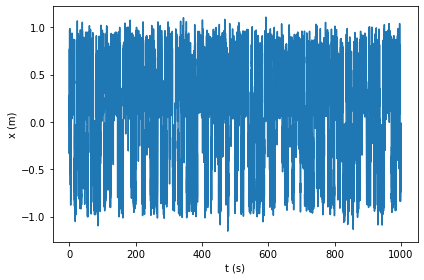

In [23]:
fig, ax = plt.subplots()
ax.plot(traj_t, traj_x)
ax.set_xlabel('t (s)')
ax.set_ylabel('x (m)')
fig.tight_layout()

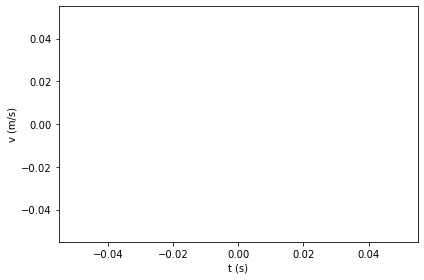

In [24]:
# N.B. Velocities are undefined for overdamped EM integrator
fig, ax = plt.subplots()
ax.plot(traj_t, traj_v)
ax.set_xlabel('t (s)')
ax.set_ylabel('v (m/s)')
fig.tight_layout()

In [25]:
# N.B. Velocities, and therefore temperature, is undefined for overdamped EM integrator
traj_T = 0.5*m*traj_v**2/(0.5*kB)
T_sim = np.mean(traj_T)
print('T_sim = %.2f K' % T_sim)

T_sim = nan K


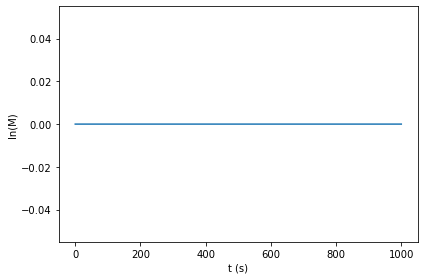

In [26]:
# N.B. For unbiased simulation all weights are unity => M = 1 => ln(M) = 0
fig, ax = plt.subplots()
ax.plot(traj_t, traj_Marg)
ax.set_xlabel('t (s)')
ax.set_ylabel('ln(M)')
fig.tight_layout()

### MSM

#### projecting into indicator function basis

In [27]:
x_min = -1.5
x_max = +1.5
assert np.min(traj_x)>x_min and np.max(traj_x)<x_max

n_bins = 50
dx = (x_max-x_min)/float(n_bins)
x_bins = np.linspace(x_min,x_max,n_bins+1)
x_mids = x_bins[:-1]+0.5*dx

In [28]:
def project_into_indicator_functions(traj_x,x_bins):
    traj_binIdx = np.digitize(traj_x, x_bins, right=True) - 1
    traj_indicator = np.zeros((traj_binIdx.size, n_bins))
    traj_indicator[np.arange(traj_binIdx.size),traj_binIdx] = 1
    return traj_indicator

In [29]:
traj_indicator = project_into_indicator_functions(traj_x,x_bins)

In [30]:
eq_distribution = np.sum(traj_indicator, axis=0)/np.shape(traj_indicator)[0]

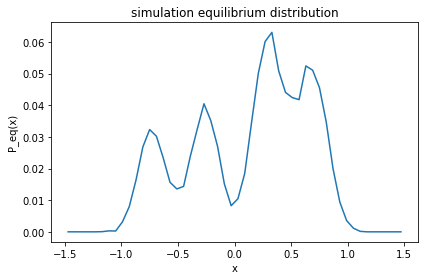

In [31]:
fig, ax = plt.subplots()
ax.plot(x_mids, eq_distribution)
ax.set_xlabel('x')
ax.set_ylabel('P_eq(x)')
plt.title('simulation equilibrium distribution')
fig.tight_layout()

In [32]:
thermo_weights = np.exp(-potential_bias(traj_x)/kT)

In [33]:
traj_indicator_reweighted = np.multiply(traj_indicator, np.tile(np.reshape(thermo_weights,(-1,1)),(1,np.shape(traj_indicator)[1])))

In [34]:
eq_distribution_reweighted = np.sum(traj_indicator_reweighted, axis=0)
eq_distribution_reweighted /= np.sum(eq_distribution_reweighted)

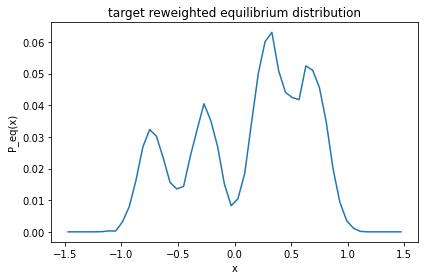

In [35]:
fig, ax = plt.subplots()
ax.plot(x_mids, eq_distribution_reweighted)
ax.set_xlabel('x')
ax.set_ylabel('P_eq(x)')
plt.title('target reweighted equilibrium distribution')
fig.tight_layout()

#### VAC

In [36]:
lag_n = 2
lag_steps = lag_n*save_mod
lag_tau = lag_n*save_mod*dt

In [37]:
assert lag_n >= 1

In [38]:
traj_indicator_0 = traj_indicator[:-lag_n]
traj_indicator_1 = traj_indicator[lag_n:]

In [39]:
K = np.shape(traj_indicator_1)[0]
pathweight = np.nan*np.ones(K)
for ii in range(0,K):
    arg = np.sum(traj_Marg[ii+1:ii+lag_n+1])
    pathweight[ii] = np.exp(arg) * thermo_weights[ii]

In [40]:
weight = pathweight

In [41]:
weight_matrix = np.tile(np.reshape(weight,(-1,1)),(1,np.shape(traj_indicator_1)[1]))

In [42]:
C00 = np.matmul(traj_indicator_0.T, np.multiply(traj_indicator_0, weight_matrix))
C01 = np.matmul(traj_indicator_0.T, np.multiply(traj_indicator_1, weight_matrix))
C10 = np.matmul(traj_indicator_1.T, np.multiply(traj_indicator_0, weight_matrix))
C11 = np.matmul(traj_indicator_1.T, np.multiply(traj_indicator_1, weight_matrix))

# assuming detailed balance (i.e., data augmentation with time reversed trajectories)
C0 = 0.5*(C00 + C11)
C1 = 0.5*(C01 + C10)

# applying regularization (nugget regularization of unpopulated bins with pseudocounts)
C0 += np.eye(C0.shape[0])*np.finfo(float).eps

evals, evecs = eigh(C1, b=C0, subset_by_index=[n_bins-4, n_bins-1])
idx = np.argsort(evals)[::-1]

evals = evals[idx]
evecs = evecs[:,idx]

In [43]:
x_MSM_unbiased = copy.deepcopy(x_mids)
evals_MSM_unbiased = copy.deepcopy(evals)
evecs_MSM_unbiased = copy.deepcopy(evecs)

In [44]:
# saving MSM evals and evecs
with open('evals_evecs_MSM_unbiased_EM.pkl', 'wb') as f:
    pickle.dump({'x_MSM_unbiased' : x_MSM_unbiased, 'evecs_MSM_unbiased' : evecs_MSM_unbiased, 'evals_MSM_unbiased' : evals_MSM_unbiased}, f)

#### plotting implied timescales

In [45]:
implied_timescales_MSM_unbiased = -lag_tau / np.log(evals_MSM_unbiased)
print(implied_timescales_MSM_unbiased)

[9.00719925e+14 1.32326710e+00 2.19710557e-01 1.15065103e-01]


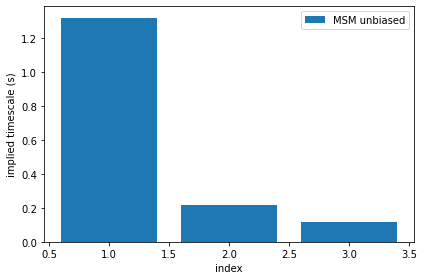

In [46]:
fig, ax = plt.subplots()
ax.bar(1+np.arange(len(implied_timescales_MSM_unbiased[1:])), implied_timescales_MSM_unbiased[1:])
ax.set_xlabel('index')
ax.set_ylabel('implied timescale (s)')
ax.legend(['MSM unbiased'])
fig.tight_layout()

#### plotting eigenvectors

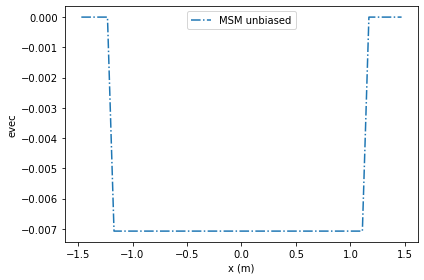

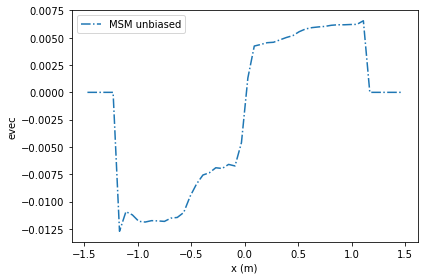

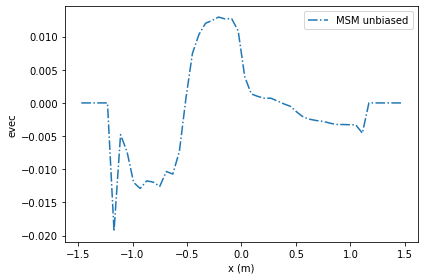

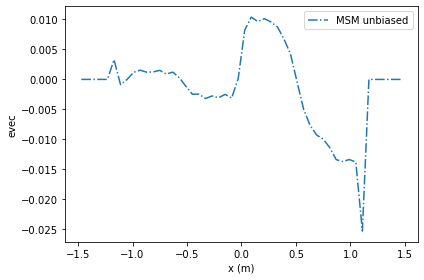

In [47]:
for ii in range(evecs.shape[1]):
    fig, ax = plt.subplots()
    ax.plot(x_MSM_unbiased, evecs_MSM_unbiased[:,ii], linestyle='dashdot')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('evec')
    ax.legend(['MSM unbiased'])
    fig.tight_layout()

### SNRV

#### featurizing trajectory (2D tensor: dim 0 = steps, dim 1 = features)

In [48]:
traj_x_featurized = traj_x
traj_x_featurized = torch.from_numpy(traj_x_featurized).float()
traj_x_featurized = torch.reshape(traj_x_featurized, (traj_x_featurized.size()[0],-1))

In [49]:
ln_dynamical_weight = torch.from_numpy(traj_Marg).float()
thermo_weight = torch.from_numpy(thermo_weights).float()

#### training SNRV

In [50]:
np.random.seed(42)
torch.manual_seed(42)

In [51]:
input_size = traj_x_featurized.size()[1]
output_size = 4
hidden_depth = 2
hidden_size = 100
batch_norm = True
dropout_rate = 0.
lr = 1E-2
weight_decay = 0.
val_frac = 0.20
n_epochs = 30
batch_size = 500
VAMPdegree = 2
is_reversible = True
num_workers = 0

model = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay, 
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size, 
            VAMPdegree=VAMPdegree, is_reversible=is_reversible, num_workers=num_workers)
model = model.to(device)

In [52]:
print(model)

Snrv(
  (activation): ReLU()
  (model): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=4, bias=True)
  )
)


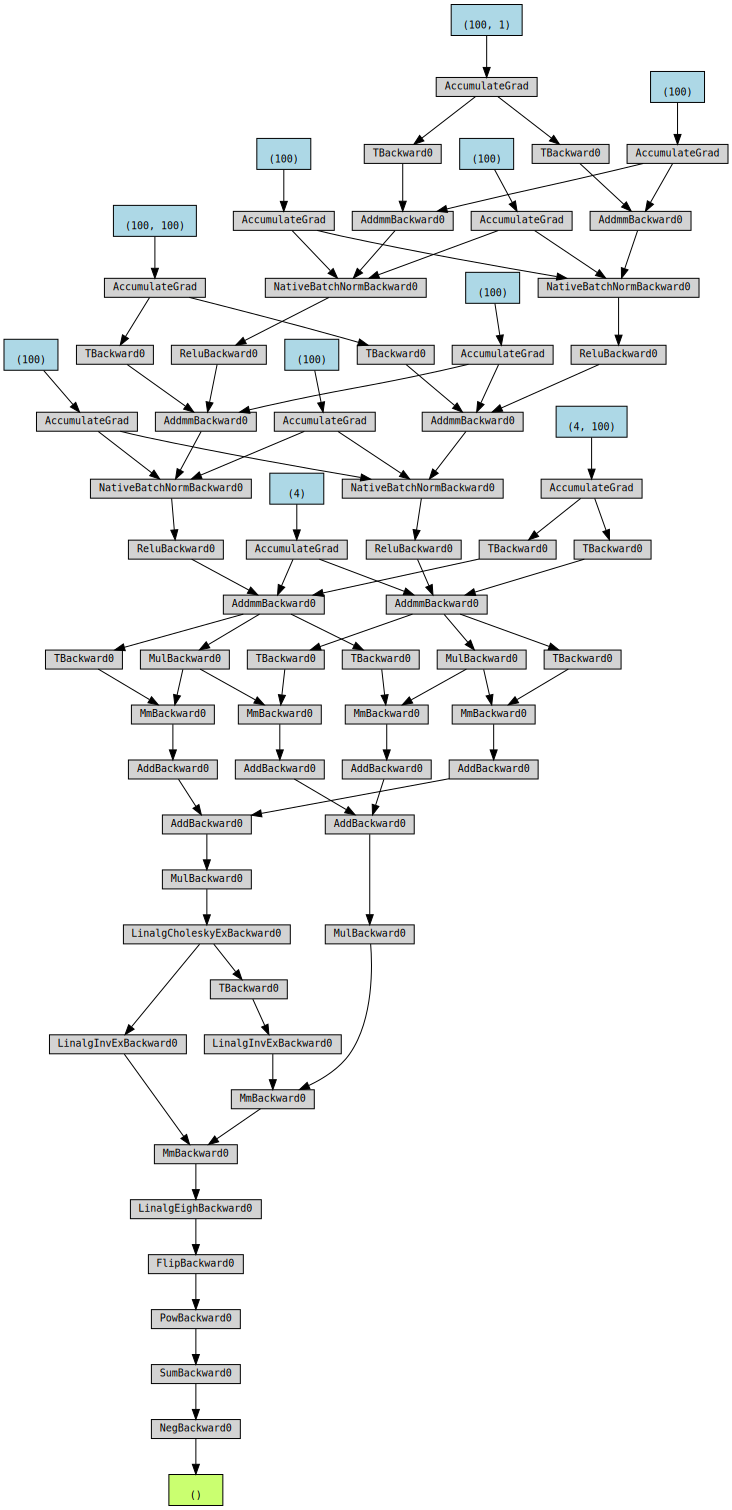

In [53]:
# plotting computational graph
x_t0 = traj_x_featurized[:-lag_n]
x_tt = traj_x_featurized[lag_n:]
z_t0, z_tt = model(x_t0, x_tt)
loss = model._loss_fn(z_t0, z_tt, torch.ones(z_tt.size()[0]))

make_dot(loss)

In [54]:
# N.B. For unbiased simulation ln_pathweight = 0. so all three of these calls are equivalent:
# - model.fit(traj_x_featurized, lag_n)
# - model.fit(traj_x_featurized, lag_n, ln_dynamical_weight=None, thermo_weight=None)
# - model.fit(traj_x_featurized, lag_n, ln_dynamical_weight=ln_dynamical_weight, thermo_weight=None)
model.fit(traj_x_featurized, lag_n)

Epoch 0: 100%|███████████████████████████████| 32/32 [00:00<00:00, 53.39batch/s]


[Epoch 0]	 training loss = -2.306	 validation loss = -2.402


Epoch 1: 100%|███████████████████████████████| 32/32 [00:00<00:00, 83.11batch/s]


[Epoch 1]	 training loss = -2.368	 validation loss = -2.415


Epoch 2: 100%|███████████████████████████████| 32/32 [00:00<00:00, 65.17batch/s]


[Epoch 2]	 training loss = -2.381	 validation loss = -2.413


Epoch 3: 100%|███████████████████████████████| 32/32 [00:00<00:00, 80.78batch/s]


[Epoch 3]	 training loss = -2.386	 validation loss = -2.438


Epoch 4: 100%|███████████████████████████████| 32/32 [00:00<00:00, 83.73batch/s]


[Epoch 4]	 training loss = -2.395	 validation loss = -2.443


Epoch 5: 100%|███████████████████████████████| 32/32 [00:00<00:00, 87.55batch/s]


[Epoch 5]	 training loss = -2.388	 validation loss = -2.416


Epoch 6: 100%|███████████████████████████████| 32/32 [00:00<00:00, 87.06batch/s]


[Epoch 6]	 training loss = -2.398	 validation loss = -2.421


Epoch 7: 100%|███████████████████████████████| 32/32 [00:00<00:00, 84.89batch/s]


[Epoch 7]	 training loss = -2.388	 validation loss = -2.439


Epoch 8: 100%|███████████████████████████████| 32/32 [00:00<00:00, 79.71batch/s]


[Epoch 8]	 training loss = -2.397	 validation loss = -2.462


Epoch 9: 100%|███████████████████████████████| 32/32 [00:00<00:00, 71.49batch/s]


[Epoch 9]	 training loss = -2.418	 validation loss = -2.460


Epoch 10: 100%|██████████████████████████████| 32/32 [00:00<00:00, 67.51batch/s]


[Epoch 10]	 training loss = -2.404	 validation loss = -2.450


Epoch 11: 100%|██████████████████████████████| 32/32 [00:00<00:00, 90.77batch/s]


[Epoch 11]	 training loss = -2.408	 validation loss = -2.457


Epoch 12: 100%|██████████████████████████████| 32/32 [00:00<00:00, 81.39batch/s]


[Epoch 12]	 training loss = -2.407	 validation loss = -2.451


Epoch 13: 100%|██████████████████████████████| 32/32 [00:00<00:00, 79.46batch/s]


[Epoch 13]	 training loss = -2.416	 validation loss = -2.446


Epoch 14: 100%|██████████████████████████████| 32/32 [00:00<00:00, 83.52batch/s]


[Epoch 14]	 training loss = -2.421	 validation loss = -2.453


Epoch 15: 100%|██████████████████████████████| 32/32 [00:00<00:00, 92.30batch/s]


[Epoch 15]	 training loss = -2.411	 validation loss = -2.464


Epoch 16: 100%|██████████████████████████████| 32/32 [00:00<00:00, 92.63batch/s]


[Epoch 16]	 training loss = -2.415	 validation loss = -2.442


Epoch 17: 100%|██████████████████████████████| 32/32 [00:00<00:00, 70.48batch/s]


[Epoch 17]	 training loss = -2.406	 validation loss = -2.440


Epoch 18: 100%|██████████████████████████████| 32/32 [00:00<00:00, 87.46batch/s]


[Epoch 18]	 training loss = -2.414	 validation loss = -2.462


Epoch 19: 100%|██████████████████████████████| 32/32 [00:00<00:00, 83.27batch/s]


[Epoch 19]	 training loss = -2.401	 validation loss = -2.457


Epoch 20: 100%|██████████████████████████████| 32/32 [00:00<00:00, 87.19batch/s]


[Epoch 20]	 training loss = -2.406	 validation loss = -2.465


Epoch 21: 100%|██████████████████████████████| 32/32 [00:00<00:00, 79.10batch/s]


[Epoch 21]	 training loss = -2.424	 validation loss = -2.464


Epoch 22: 100%|██████████████████████████████| 32/32 [00:00<00:00, 96.12batch/s]


[Epoch 22]	 training loss = -2.415	 validation loss = -2.462


Epoch 23: 100%|██████████████████████████████| 32/32 [00:00<00:00, 86.53batch/s]


[Epoch 23]	 training loss = -2.423	 validation loss = -2.468


Epoch 24: 100%|██████████████████████████████| 32/32 [00:00<00:00, 78.83batch/s]


[Epoch 24]	 training loss = -2.420	 validation loss = -2.456


Epoch 25: 100%|██████████████████████████████| 32/32 [00:00<00:00, 88.68batch/s]


[Epoch 25]	 training loss = -2.412	 validation loss = -2.459


Epoch 26: 100%|██████████████████████████████| 32/32 [00:00<00:00, 63.95batch/s]


[Epoch 26]	 training loss = -2.400	 validation loss = -2.458


Epoch 27: 100%|██████████████████████████████| 32/32 [00:00<00:00, 89.03batch/s]


[Epoch 27]	 training loss = -2.416	 validation loss = -2.463


Epoch 28: 100%|██████████████████████████████| 32/32 [00:00<00:00, 80.83batch/s]


[Epoch 28]	 training loss = -2.428	 validation loss = -2.468


Epoch 29: 100%|██████████████████████████████| 32/32 [00:00<00:00, 94.01batch/s]


[Epoch 29]	 training loss = -2.407	 validation loss = -2.464


In [55]:
# saving trained SRV model
saveFile = 'model_SRV_unbiased_EM.pt'
model.save_model(saveFile)

#### plotting training and validation curves

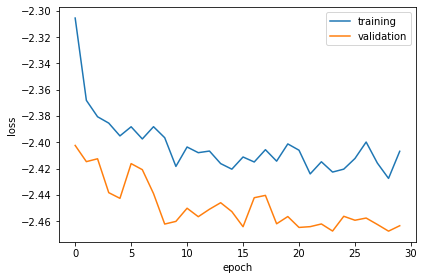

In [56]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.training_losses)), model.training_losses)
ax.plot(np.arange(len(model.validation_losses)), model.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

#### plotting implied timescales

In [57]:
evals_SRV_unbiased = copy.deepcopy(model.evals.cpu().detach().numpy())

In [58]:
implied_timescales_SRV_unbiased = -lag_tau / np.log(evals_SRV_unbiased)
print(implied_timescales_SRV_unbiased)

[3.5925017e+03 1.2903109e+00 2.1676509e-01 1.1342337e-01]


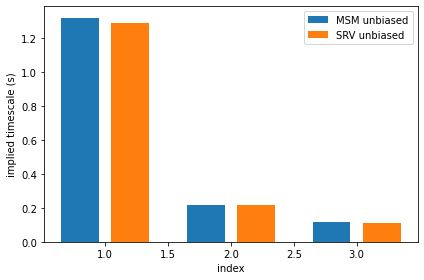

In [59]:
fig, ax = plt.subplots()
ax.bar(1+np.arange(len(implied_timescales_MSM_unbiased[1:]))-0.2, implied_timescales_MSM_unbiased[1:], width=0.3)
ax.bar(1+np.arange(len(implied_timescales_SRV_unbiased[1:]))+0.2, implied_timescales_SRV_unbiased[1:], width=0.3)
ax.set_xlabel('index')
ax.set_ylabel('implied timescale (s)')
ax.legend(['MSM unbiased','SRV unbiased'])
fig.tight_layout()

#### plotting eigenvectors

In [60]:
x_SRV_unbiased = np.linspace(-1.5, 1.5, 250)
x_SRV_unbiased = np.reshape(x_SRV_unbiased, (x_SRV_unbiased.shape[0],-1))

In [61]:
evecs_SRV_unbiased = copy.deepcopy(model.transform( torch.from_numpy(x_SRV_unbiased).float() ).cpu().detach().numpy())

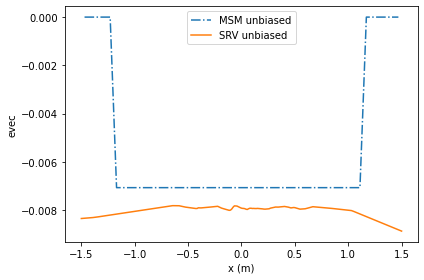

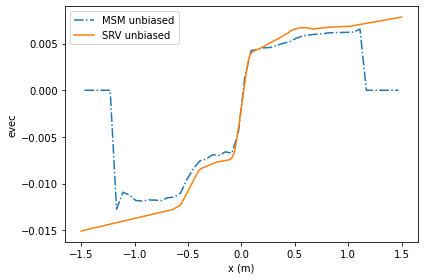

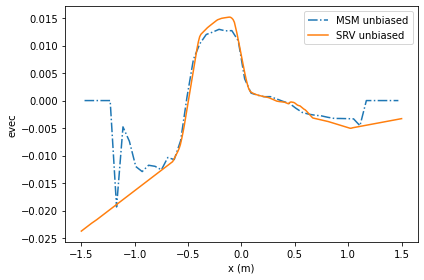

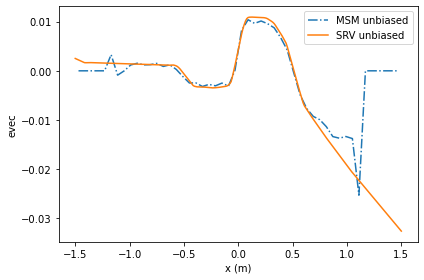

In [62]:
for ii in range(evecs_SRV_unbiased.shape[1]):
    fig, ax = plt.subplots()
    
    ax.plot(x_MSM_unbiased, evecs_MSM_unbiased[:,ii], linestyle='dashdot')
    
    # matching arbitrary sign of evecs_SRV_unbiased with evecs_MSM_unbiased
    evecs_SRV_unbiased_ii_interp = np.interp(x_MSM_unbiased, x_SRV_unbiased.flatten(), evecs_SRV_unbiased[:,ii])
    if np.mean(np.abs(evecs_MSM_unbiased[:,ii]-evecs_SRV_unbiased_ii_interp)) < np.mean(np.abs(evecs_MSM_unbiased[:,ii]+evecs_SRV_unbiased_ii_interp)):
        ax.plot(x_SRV_unbiased, evecs_SRV_unbiased[:,ii])
    else:
        ax.plot(x_SRV_unbiased, -evecs_SRV_unbiased[:,ii])
    
    ax.set_xlabel('x (m)')
    ax.set_ylabel('evec')
    ax.legend(['MSM unbiased','SRV unbiased'])
    fig.tight_layout()

In [63]:
# saving unbiased SRV evals and evecs
with open('evals_evecs_SRV_unbiased_EM.pkl', 'wb') as f:
    pickle.dump({'x_SRV_unbiased' : x_SRV_unbiased, 'evecs_SRV_unbiased' : evecs_SRV_unbiased, 'evals_SRV_unbiased' : evals_SRV_unbiased}, f)

## 2. simulation w/ bias (target potential = 4-well potential; simulation potential = 2-well potential)

#### bias : U_bias = V_target - V_sim 
#### N.B. *** Bias is defined as what is ADDED to simulation potential to get target potential == what is SUBTRACTED from target potential to get simulation potential; opposite from usual convention ***

In [64]:
def potential_bias(x):
    V = potential_target(x) - potential_2well(x) # U_bias = V_target - V_2well => V_sim = 2well
    return V

In [65]:
def force_bias(x):
    f = force_target(x) - force_2well(x) # f_bias = f_target - f_2well => f_sim = f_2well
    return f

### running simulation

In [66]:
traj_step, traj_t, traj_x, traj_v, traj_Marg = run_sim(x0,v0,xi,m,kT,dt,n_steps,save_mod,force_target,force_bias,integrator)

In [67]:
# saving trajectory
with open('traj_biased_EM.pkl', 'wb') as f:
    pickle.dump({'traj_step' : traj_step, 'traj_t' : traj_t, 'traj_x' : traj_x, 'traj_v' : traj_v, 'traj_Marg' : traj_Marg}, f)    

### analyzing trajectory

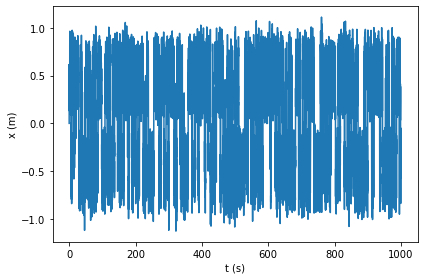

In [68]:
fig, ax = plt.subplots()
ax.plot(traj_t, traj_x)
ax.set_xlabel('t (s)')
ax.set_ylabel('x (m)')
fig.tight_layout()

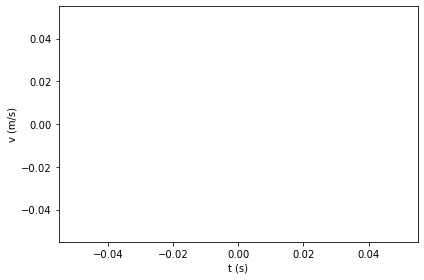

In [69]:
# N.B. Velocities are undefined for overdamped EM integrator
fig, ax = plt.subplots()
ax.plot(traj_t, traj_v)
ax.set_xlabel('t (s)')
ax.set_ylabel('v (m/s)')
fig.tight_layout()

In [70]:
# N.B. Velocities, and therefore temperature, is undefined for overdamped EM integrator
traj_T = 0.5*m*traj_v**2/(0.5*kB)
T_sim = np.mean(traj_T)
print('T_sim = %.2f K' % T_sim)

T_sim = nan K


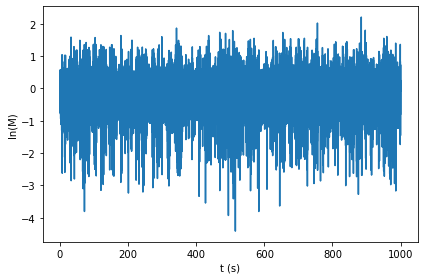

In [71]:
fig, ax = plt.subplots()
ax.plot(traj_t, traj_Marg)
ax.set_xlabel('t (s)')
ax.set_ylabel('ln(M)')
fig.tight_layout()

### MSM

#### projecting into indicator function basis

In [72]:
x_min = -1.5
x_max = +1.5
assert np.min(traj_x)>x_min and np.max(traj_x)<x_max

n_bins = 50
dx = (x_max-x_min)/float(n_bins)
x_bins = np.linspace(x_min,x_max,n_bins+1)
x_mids = x_bins[:-1]+0.5*dx

In [73]:
def project_into_indicator_functions(traj_x,x_bins):
    traj_binIdx = np.digitize(traj_x, x_bins, right=True) - 1
    traj_indicator = np.zeros((traj_binIdx.size, n_bins))
    traj_indicator[np.arange(traj_binIdx.size),traj_binIdx] = 1
    return traj_indicator

In [74]:
traj_indicator = project_into_indicator_functions(traj_x,x_bins)

In [75]:
eq_distribution = np.sum(traj_indicator, axis=0)/np.shape(traj_indicator)[0]

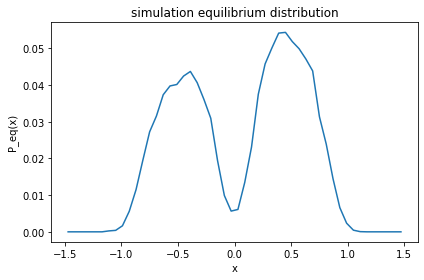

In [76]:
fig, ax = plt.subplots()
ax.plot(x_mids, eq_distribution)
ax.set_xlabel('x')
ax.set_ylabel('P_eq(x)')
plt.title('simulation equilibrium distribution')
fig.tight_layout()

In [77]:
thermo_weights = np.exp(-potential_bias(traj_x)/kT)

In [78]:
traj_indicator_reweighted = np.multiply(traj_indicator, np.tile(np.reshape(thermo_weights,(-1,1)),(1,np.shape(traj_indicator)[1])))

In [79]:
eq_distribution_reweighted = np.sum(traj_indicator_reweighted, axis=0)
eq_distribution_reweighted /= np.sum(eq_distribution_reweighted)

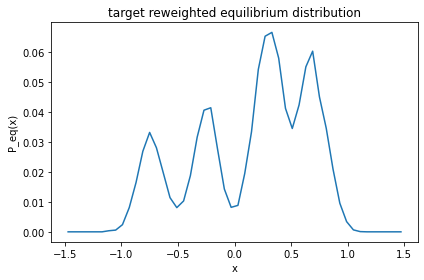

In [80]:
fig, ax = plt.subplots()
ax.plot(x_mids, eq_distribution_reweighted)
ax.set_xlabel('x')
ax.set_ylabel('P_eq(x)')
plt.title('target reweighted equilibrium distribution')
fig.tight_layout()

#### VAC

In [81]:
lag_n = 2
lag_steps = lag_n*save_mod
lag_tau = lag_n*save_mod*dt

In [82]:
assert lag_n >= 1

In [83]:
traj_indicator_0 = traj_indicator[:-lag_n]
traj_indicator_1 = traj_indicator[lag_n:]

In [84]:
K = np.shape(traj_indicator_1)[0]
pathweight = np.nan*np.ones(K)
for ii in range(0,K):
    arg = np.sum(traj_Marg[ii+1:ii+ lag_n + 1])
    pathweight[ii] = np.exp(arg) * thermo_weights[ii]

In [85]:
weight = pathweight

In [86]:
weight_matrix = np.tile(np.reshape(weight,(-1,1)),(1,np.shape(traj_indicator_1)[1]))

In [87]:
C00 = np.matmul(traj_indicator_0.T, np.multiply(traj_indicator_0, weight_matrix))
C01 = np.matmul(traj_indicator_0.T, np.multiply(traj_indicator_1, weight_matrix))
C10 = np.matmul(traj_indicator_1.T, np.multiply(traj_indicator_0, weight_matrix))
C11 = np.matmul(traj_indicator_1.T, np.multiply(traj_indicator_1, weight_matrix))

# assuming detailed balance (i.e., data augmentation with time reversed trajectories)
C0 = 0.5*(C00 + C11)
C1 = 0.5*(C01 + C10)

# applying regularization (nugget regularization of unpopulated bins with pseudocounts)
C0 += np.eye(C0.shape[0])*np.finfo(float).eps

evals, evecs = eigh(C1, b=C0, subset_by_index=[n_bins-4, n_bins-1])
idx = np.argsort(evals)[::-1]

evals = evals[idx]
evecs = evecs[:,idx]

In [88]:
x_MSM_biased = copy.deepcopy(x_mids)
evals_MSM_biased = copy.deepcopy(evals)
evecs_MSM_biased = copy.deepcopy(evecs)

In [89]:
# saving biased MSM evals and evecs
with open('evals_evecs_MSM_biased_EM.pkl', 'wb') as f:
    pickle.dump({'x_MSM_biased' : x_MSM_biased, 'evecs_MSM_biased' : evecs_MSM_biased, 'evals_MSM_biased' : evals_MSM_biased}, f)

#### plotting implied timescales

In [90]:
implied_timescales_MSM_biased = -lag_tau / np.log(evals_MSM_biased)
print(implied_timescales_MSM_biased)

[      -inf 1.35072811 0.22256757 0.11671405]


/anaconda/envs/torch4/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


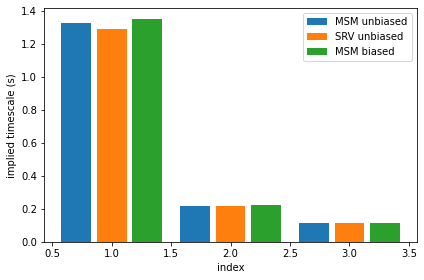

In [91]:
fig, ax = plt.subplots()
ax.bar(1+np.arange(len(implied_timescales_MSM_unbiased[1:]))-0.3, implied_timescales_MSM_unbiased[1:], width=0.25)
ax.bar(1+np.arange(len(implied_timescales_SRV_unbiased[1:])), implied_timescales_SRV_unbiased[1:], width=0.25)
ax.bar(1+np.arange(len(implied_timescales_MSM_biased[1:]))+0.3, implied_timescales_MSM_biased[1:], width=0.25)
ax.set_xlabel('index')
ax.set_ylabel('implied timescale (s)')
ax.legend(['MSM unbiased','SRV unbiased','MSM biased'])
fig.tight_layout()

#### plotting eigenvectors

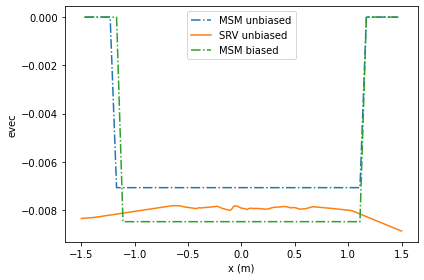

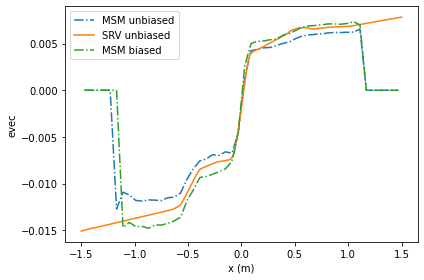

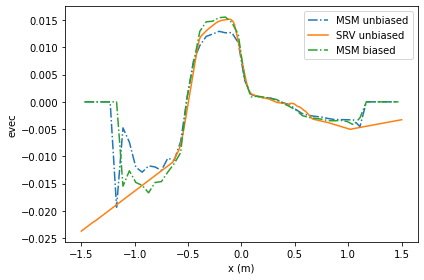

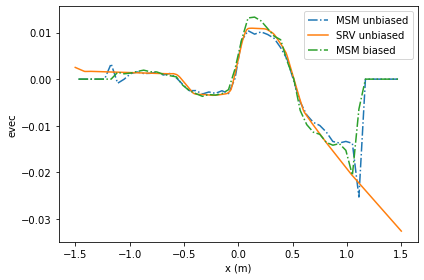

In [92]:
for ii in range(evecs.shape[1]):
    fig, ax = plt.subplots()
    
    ax.plot(x_MSM_unbiased, evecs_MSM_unbiased[:,ii], linestyle='dashdot')
    
    # matching arbitrary sign of evecs_SRV_unbiased with evecs_MSM_unbiased
    evecs_SRV_unbiased_ii_interp = np.interp(x_MSM_unbiased, x_SRV_unbiased.flatten(), evecs_SRV_unbiased[:,ii])
    if np.mean(np.abs(evecs_MSM_unbiased[:,ii]-evecs_SRV_unbiased_ii_interp)) < np.mean(np.abs(evecs_MSM_unbiased[:,ii]+evecs_SRV_unbiased_ii_interp)):
        ax.plot(x_SRV_unbiased, evecs_SRV_unbiased[:,ii])
    else:
        ax.plot(x_SRV_unbiased, -evecs_SRV_unbiased[:,ii])
    
    # matching arbitrary sign of evecs_MSM_biased with evecs_MSM_unbiased
    evecs_MSM_biased_ii_interp = np.interp(x_MSM_unbiased, x_MSM_biased.flatten(), evecs_MSM_biased[:,ii])
    if np.mean(np.abs(evecs_MSM_unbiased[:,ii]-evecs_MSM_biased_ii_interp)) < np.mean(np.abs(evecs_MSM_unbiased[:,ii]+evecs_MSM_biased_ii_interp)):
        ax.plot(x_MSM_biased, evecs_MSM_biased[:,ii], linestyle='dashdot')
    else:
        ax.plot(x_MSM_biased, -evecs_MSM_biased[:,ii], linestyle='dashdot')
    
    ax.set_xlabel('x (m)')
    ax.set_ylabel('evec')
    ax.legend(['MSM unbiased','SRV unbiased','MSM biased'])
    fig.tight_layout()

### SNRV

#### featurizing trajectory (2D tensor: dim 0 = steps, dim 1 = features)

In [93]:
traj_x_featurized = traj_x
traj_x_featurized = torch.from_numpy(traj_x_featurized).float()
traj_x_featurized = torch.reshape(traj_x_featurized, (traj_x_featurized.size()[0],-1))

In [94]:
ln_dynamical_weight = torch.from_numpy(traj_Marg).float()
thermo_weight = torch.from_numpy(thermo_weights).float()

#### training SNRV

In [95]:
np.random.seed(42)
torch.manual_seed(42)

In [96]:
input_size = traj_x_featurized.size()[1]
output_size = 4
hidden_depth = 2
hidden_size = 100
batch_norm = True
dropout_rate = 0.
lr = 1E-2
weight_decay = 0.
val_frac = 0.20
n_epochs = 30
batch_size = 500
VAMPdegree = 2
is_reversible = True
num_workers = 0

model = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay, 
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size, 
            VAMPdegree=VAMPdegree, is_reversible=is_reversible, num_workers=num_workers)
model = model.to(device)

In [97]:
print(model)

Snrv(
  (activation): ReLU()
  (model): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=4, bias=True)
  )
)


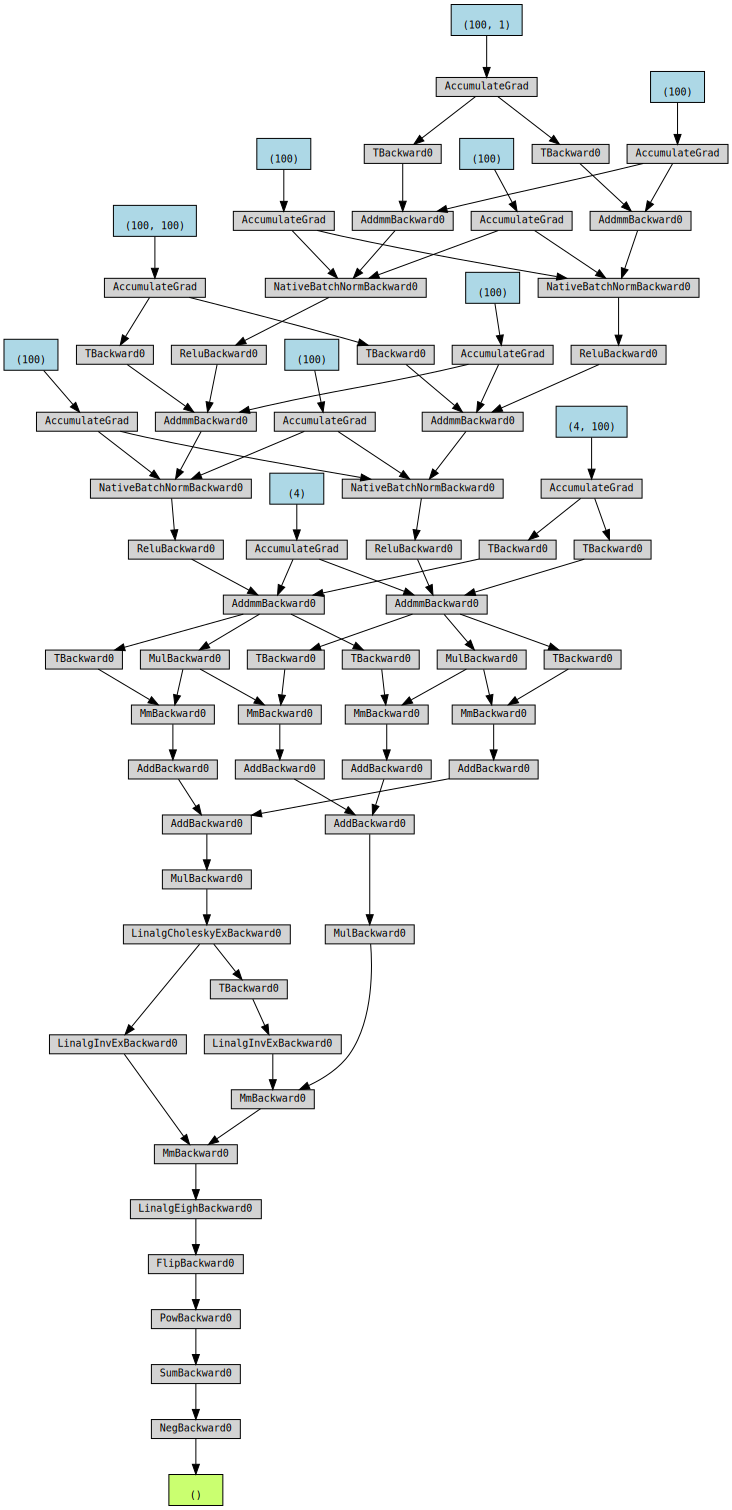

In [98]:
# plotting computational graph
x_t0 = traj_x_featurized[:-lag_n]
x_tt = traj_x_featurized[lag_n:]
z_t0, z_tt = model(x_t0, x_tt)
loss = model._loss_fn(z_t0, z_tt, torch.ones(z_tt.size()[0]))

make_dot(loss)

In [99]:
model.fit(traj_x_featurized, lag_n, ln_dynamical_weight=ln_dynamical_weight, thermo_weight=thermo_weight)

Epoch 0: 100%|███████████████████████████████| 32/32 [00:00<00:00, 82.77batch/s]


[Epoch 0]	 training loss = -2.311	 validation loss = -2.429


Epoch 1: 100%|███████████████████████████████| 32/32 [00:00<00:00, 70.94batch/s]


[Epoch 1]	 training loss = -2.379	 validation loss = -2.444


Epoch 2: 100%|███████████████████████████████| 32/32 [00:00<00:00, 65.01batch/s]


[Epoch 2]	 training loss = -2.397	 validation loss = -2.455


Epoch 3: 100%|███████████████████████████████| 32/32 [00:00<00:00, 54.09batch/s]


[Epoch 3]	 training loss = -2.411	 validation loss = -2.462


Epoch 4: 100%|███████████████████████████████| 32/32 [00:00<00:00, 66.41batch/s]


[Epoch 4]	 training loss = -2.417	 validation loss = -2.473


Epoch 5: 100%|███████████████████████████████| 32/32 [00:00<00:00, 69.76batch/s]


[Epoch 5]	 training loss = -2.411	 validation loss = -2.456


Epoch 6: 100%|███████████████████████████████| 32/32 [00:00<00:00, 78.24batch/s]


[Epoch 6]	 training loss = -2.417	 validation loss = -2.470


Epoch 7: 100%|███████████████████████████████| 32/32 [00:00<00:00, 86.53batch/s]


[Epoch 7]	 training loss = -2.413	 validation loss = -2.461


Epoch 8: 100%|███████████████████████████████| 32/32 [00:00<00:00, 72.56batch/s]


[Epoch 8]	 training loss = -2.424	 validation loss = -2.472


Epoch 9: 100%|███████████████████████████████| 32/32 [00:00<00:00, 91.49batch/s]


[Epoch 9]	 training loss = -2.426	 validation loss = -2.473


Epoch 10: 100%|██████████████████████████████| 32/32 [00:00<00:00, 81.46batch/s]


[Epoch 10]	 training loss = -2.423	 validation loss = -2.475


Epoch 11: 100%|██████████████████████████████| 32/32 [00:00<00:00, 81.62batch/s]


[Epoch 11]	 training loss = -2.410	 validation loss = -2.467


Epoch 12: 100%|██████████████████████████████| 32/32 [00:00<00:00, 76.85batch/s]


[Epoch 12]	 training loss = -2.430	 validation loss = -2.481


Epoch 13: 100%|██████████████████████████████| 32/32 [00:00<00:00, 82.31batch/s]


[Epoch 13]	 training loss = -2.424	 validation loss = -2.476


Epoch 14: 100%|██████████████████████████████| 32/32 [00:00<00:00, 85.05batch/s]


[Epoch 14]	 training loss = -2.422	 validation loss = -2.476


Epoch 15: 100%|██████████████████████████████| 32/32 [00:00<00:00, 77.10batch/s]


[Epoch 15]	 training loss = -2.423	 validation loss = -2.475


Epoch 16: 100%|██████████████████████████████| 32/32 [00:00<00:00, 84.71batch/s]


[Epoch 16]	 training loss = -2.434	 validation loss = -2.480


Epoch 17: 100%|██████████████████████████████| 32/32 [00:00<00:00, 82.62batch/s]


[Epoch 17]	 training loss = -2.428	 validation loss = -2.476


Epoch 18: 100%|██████████████████████████████| 32/32 [00:00<00:00, 82.07batch/s]


[Epoch 18]	 training loss = -2.434	 validation loss = -2.482


Epoch 19: 100%|██████████████████████████████| 32/32 [00:00<00:00, 74.53batch/s]


[Epoch 19]	 training loss = -2.433	 validation loss = -2.477


Epoch 20: 100%|██████████████████████████████| 32/32 [00:00<00:00, 84.42batch/s]


[Epoch 20]	 training loss = -2.427	 validation loss = -2.478


Epoch 21: 100%|██████████████████████████████| 32/32 [00:00<00:00, 84.36batch/s]


[Epoch 21]	 training loss = -2.433	 validation loss = -2.476


Epoch 22: 100%|██████████████████████████████| 32/32 [00:00<00:00, 63.58batch/s]


[Epoch 22]	 training loss = -2.432	 validation loss = -2.475


Epoch 23: 100%|██████████████████████████████| 32/32 [00:00<00:00, 64.75batch/s]


[Epoch 23]	 training loss = -2.429	 validation loss = -2.481


Epoch 24: 100%|██████████████████████████████| 32/32 [00:00<00:00, 79.60batch/s]


[Epoch 24]	 training loss = -2.428	 validation loss = -2.480


Epoch 25: 100%|██████████████████████████████| 32/32 [00:00<00:00, 83.00batch/s]


[Epoch 25]	 training loss = -2.426	 validation loss = -2.474


Epoch 26: 100%|██████████████████████████████| 32/32 [00:00<00:00, 77.23batch/s]


[Epoch 26]	 training loss = -2.421	 validation loss = -2.479


Epoch 27: 100%|██████████████████████████████| 32/32 [00:00<00:00, 74.93batch/s]


[Epoch 27]	 training loss = -2.431	 validation loss = -2.471


Epoch 28: 100%|██████████████████████████████| 32/32 [00:00<00:00, 88.28batch/s]


[Epoch 28]	 training loss = -2.431	 validation loss = -2.477


Epoch 29: 100%|██████████████████████████████| 32/32 [00:00<00:00, 83.65batch/s]


[Epoch 29]	 training loss = -2.423	 validation loss = -2.474


In [100]:
# saving trained SRV model
saveFile = 'model_SRV_biased_EM.pt'
model.save_model(saveFile)

#### plotting training and validation curves

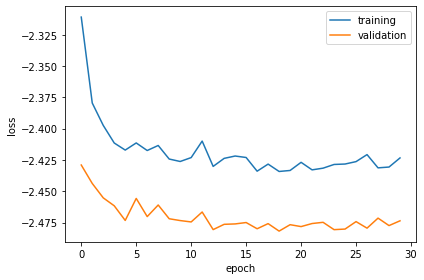

In [101]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.training_losses)), model.training_losses)
ax.plot(np.arange(len(model.validation_losses)), model.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

#### plotting implied timescales

In [102]:
evals_SRV_biased = copy.deepcopy(model.evals.cpu().detach().numpy())

In [103]:
implied_timescales_SRV_biased = -lag_tau / np.log(evals_SRV_biased)
print(implied_timescales_SRV_biased)

[1.2501152e+03 1.3509264e+00 2.0958745e-01 1.1670543e-01]


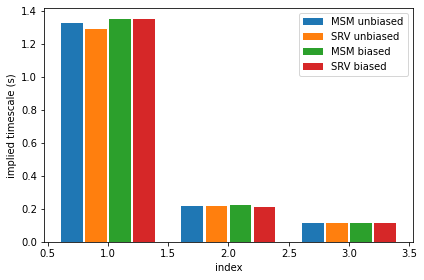

In [104]:
fig, ax = plt.subplots()
ax.bar(1+np.arange(len(implied_timescales_MSM_unbiased[1:]))-0.3, implied_timescales_MSM_unbiased[1:], width=0.18)
ax.bar(1+np.arange(len(implied_timescales_SRV_unbiased[1:]))-0.1, implied_timescales_SRV_unbiased[1:], width=0.18)
ax.bar(1+np.arange(len(implied_timescales_MSM_biased[1:]))+0.1, implied_timescales_MSM_biased[1:], width=0.18)
ax.bar(1+np.arange(len(implied_timescales_SRV_biased[1:]))+0.3, implied_timescales_SRV_biased[1:], width=0.18)
ax.set_xlabel('index')
ax.set_ylabel('implied timescale (s)')
ax.legend(['MSM unbiased','SRV unbiased','MSM biased','SRV biased'])
fig.tight_layout()

#### plotting eigenvectors

In [105]:
x_SRV_biased = np.linspace(-1.5, 1.5, 250)
x_SRV_biased = np.reshape(x_SRV_biased, (x_SRV_biased.shape[0],-1))

In [106]:
evecs_SRV_biased = copy.deepcopy(model.transform( torch.from_numpy(x_SRV_biased).float() ).cpu().detach().numpy())

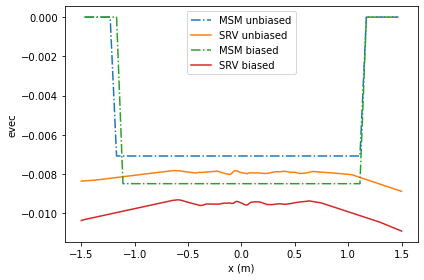

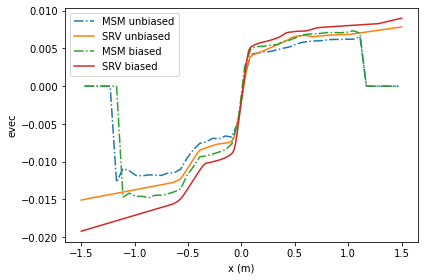

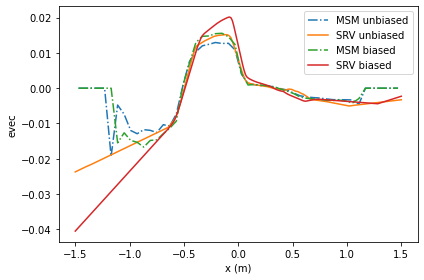

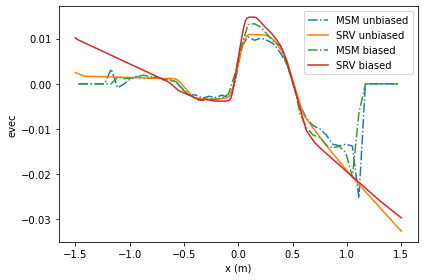

In [107]:
for ii in range(evecs.shape[1]):
    fig, ax = plt.subplots()
    
    ax.plot(x_MSM_unbiased, evecs_MSM_unbiased[:,ii], linestyle='dashdot')
    
    # matching arbitrary sign of evecs_SRV_unbiased with evecs_MSM_unbiased
    evecs_SRV_unbiased_ii_interp = np.interp(x_MSM_unbiased, x_SRV_unbiased.flatten(), evecs_SRV_unbiased[:,ii])
    if np.mean(np.abs(evecs_MSM_unbiased[:,ii]-evecs_SRV_unbiased_ii_interp)) < np.mean(np.abs(evecs_MSM_unbiased[:,ii]+evecs_SRV_unbiased_ii_interp)):
        ax.plot(x_SRV_unbiased, evecs_SRV_unbiased[:,ii])
    else:
        ax.plot(x_SRV_unbiased, -evecs_SRV_unbiased[:,ii])
    
    # matching arbitrary sign of evecs_MSM_biased with evecs_MSM_unbiased
    evecs_MSM_biased_ii_interp = np.interp(x_MSM_unbiased, x_MSM_biased.flatten(), evecs_MSM_biased[:,ii])
    if np.mean(np.abs(evecs_MSM_unbiased[:,ii]-evecs_MSM_biased_ii_interp)) < np.mean(np.abs(evecs_MSM_unbiased[:,ii]+evecs_MSM_biased_ii_interp)):
        ax.plot(x_MSM_biased, evecs_MSM_biased[:,ii], linestyle='dashdot')
    else:
        ax.plot(x_MSM_biased, -evecs_MSM_biased[:,ii], linestyle='dashdot')
    
    # matching arbitrary sign of evecs_SRV_biased with evecs_MSM_unbiased
    evecs_SRV_biased_ii_interp = np.interp(x_MSM_unbiased, x_SRV_biased.flatten(), evecs_SRV_biased[:,ii])
    if np.mean(np.abs(evecs_MSM_unbiased[:,ii]-evecs_SRV_biased_ii_interp)) < np.mean(np.abs(evecs_MSM_unbiased[:,ii]+evecs_SRV_biased_ii_interp)):
        ax.plot(x_SRV_biased, evecs_SRV_biased[:,ii])
    else:
        ax.plot(x_SRV_biased, -evecs_SRV_biased[:,ii])
    
    ax.set_xlabel('x (m)')
    ax.set_ylabel('evec')
    ax.legend(['MSM unbiased','SRV unbiased','MSM biased','SRV biased'])
    fig.tight_layout()

In [108]:
# saving biased SRV evals and evecs
with open('evals_evecs_SRV_biased_EM.pkl', 'wb') as f:
    pickle.dump({'x_SRV_biased' : x_MSM_biased, 'evecs_SRV_biased' : evecs_MSM_biased, 'evals_SRV_biased' : evals_MSM_biased}, f)